In [1]:
if not globals().get('spark') : 
    !pip install  -q pyspark-client --upgrade
    !pip install     https://github.com/djouallah/sail/releases/download/na/pysail-0.4.6-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
    notebookutils.session.restartPython()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 28.4 MB/s eta 0:00:0000:0100:01
sys.exit called with value 0. The interpreter will be restarted.


In [2]:
ws               = 'tpch'
lh               = 'raw'
SF               =  10
table_results    = f'abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.Lakehouse/Tables/dbo/result'

In [3]:
if not globals().get('spark') : 
   engine = 'lakesail'
else :
   engine = 'velox'

In [4]:
from   datetime           import datetime
from   pyspark.sql        import SparkSession , functions as F
from   pyspark.sql.types  import StructType, StructField, FloatType, IntegerType, LongType
from   datetime           import datetime
from   psutil             import *
import time
import os

In [5]:
if engine == 'lakesail' : 
    from   pysail.spark       import SparkConnectServer
    os.environ["SAIL_CATALOG__LIST"] = f'[{{type="onelake", name="onelake", url="{ws}/{lh}.Lakehouse"}}]'
    os.environ["SAIL_CATALOG__DEFAULT_CATALOG"] = "onelake"
    os.environ["AZURE_STORAGE_TOKEN"] = notebookutils.credentials.getToken("storage")
    server = SparkConnectServer()
    server.start()
    _, port = server.listening_address
    spark = SparkSession.builder.remote(f"sc://localhost:{port}").getOrCreate()
    spark.sql("show schemas").show()
else :
    spark.conf.set("spark.sql.caseSensitive", "true")

+------+-------+-----------+------------+
|  name|catalog|description|location_uri|
+------+-------+-----------+------------+
|CH0001|onelake|       NULL|        NULL|
|CH0002|onelake|       NULL|        NULL|
|CH0003|onelake|       NULL|        NULL|
|CH0010|onelake|       NULL|        NULL|
|CH0020|onelake|       NULL|        NULL|
|CH0025|onelake|       NULL|        NULL|
|CH0030|onelake|       NULL|        NULL|
|CH0050|onelake|       NULL|        NULL|
|CH0100|onelake|       NULL|        NULL|
|CH1000|onelake|       NULL|        NULL|
|   dbo|onelake|       NULL|        NULL|
+------+-------+-----------+------------+



# Generate Data

In [6]:
%%time
import pathlib
schema = f'CH{SF:04d}'
tpch_tables = ['nation','region','customer','supplier','lineitem','orders','partsupp','part']
Table_Path = '/lakehouse/default/Tables'
lineitem_parts = max(2, int(200 * (SF / 1000)))
orders_parts   = max(2, int(140 * (SF / 1000)))
partsupp_parts = max(1, int(80 * (SF / 1000)))
part_parts     = max(1, int(12 * (SF / 1000)))
customer_parts = max(1, int(20 * (SF / 1000)))

def script(BASE_OUTPUT_DIR):
    return  f"""
    set -e

    SCALE_FACTOR={SF}
    BASE_OUTPUT_DIR="{BASE_OUTPUT_DIR}"
    declare -A TABLES_PARTS=(
        ["lineitem"]={lineitem_parts}
        ["orders"]={orders_parts}
        ["partsupp"]={partsupp_parts}
        ["part"]={part_parts}
        ["customer"]={customer_parts}
        ["nation"]=1
        ["region"]=1
        ["supplier"]=1
    )
    echo "--- Starting TPC-H Data Generation ---"
    echo "Scale Factor: ${{SCALE_FACTOR}}"
    echo "Base Output Directory: ${{BASE_OUTPUT_DIR}}"
    echo ""

    for table_name in "${{!TABLES_PARTS[@]}}"; do
        num_parts_to_generate="${{TABLES_PARTS[${{table_name}}]}}"
        echo "--- Generating data for table: ${{table_name}} (${{num_parts_to_generate}} parts) ---"
        echo "  -> Generating ${{table_name}} part ${{i}}/${{num_parts_to_generate}} "
            tpchgen-cli \\
                -s "${{SCALE_FACTOR}}" \\
                --tables "${{table_name}}" \\
                --output-dir "${{BASE_OUTPUT_DIR}}" \\
                --parts "${{num_parts_to_generate}}" \\
                --format="parquet" \\
                --parquet-row-group-bytes=268435456
        done
        echo "--- Finished generating data for table: ${{table_name}} ---"
    echo "--- TPC-H Data Generation Complete! ---"
    """

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 15.7 µs


In [7]:
try:
    df = spark.sql(f"show tables from {schema}")
    if df.count() >= 8:
      print(' data exist')
except:
    notebookutils.fs.mount(f"abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.lakehouse", "/tpch")
    !pip install -q tpchgen-cli
    !pip install deltalake
    from   deltalake  import convert_to_deltalake
    print('generate new data')
    BASE_OUTPUT_DIR = notebookutils.fs.getMountPath("/tpch")+f"/Tables/{schema}"
    get_ipython().system(script(BASE_OUTPUT_DIR))
    for tbl in tpch_tables:
      convert_to_deltalake(f'{BASE_OUTPUT_DIR}/{tbl}',storage_options={"allow_unsafe_rename":"true"})

 data exist


In [8]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
core

2

# SQL Query

In [9]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;



WITH cheapest_part AS (
    SELECT
        MIN(ps.ps_supplycost) AS cp_lowest,
        p.p_partkey AS cp_partkey
    FROM part p
    JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
    JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
    JOIN nation n ON s.s_nationkey = n.n_nationkey
    JOIN region r ON n.n_regionkey = r.r_regionkey
    WHERE r.r_name = 'EUROPE'
    GROUP BY p.p_partkey
)
SELECT
    s.s_acctbal,
    s.s_name,
    n.n_name,
    p.p_partkey,
    p.p_mfgr,
    s.s_address,
    s.s_phone,
    s.s_comment
FROM part p
JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
JOIN region r ON n.n_regionkey = r.r_regionkey
JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
WHERE p.p_size = 15
  AND p.p_type LIKE '%BRASS'
  AND r.r_name = 'EUROPE'
ORDER BY s.s_acctbal DESC,
         n.n_name,
         s.s_name,
         p.p_partkey
LIMIT 10;









SELECT
    l.l_orderkey,
    SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
    o.o_orderdate,
    o.o_shippriority
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON l.l_orderkey = o.o_orderkey
WHERE
    c.c_mktsegment = 'BUILDING'
    AND o.o_orderdate < CAST('1995-03-15' AS DATE)
    AND l.l_shipdate > CAST('1995-03-15' AS DATE)
GROUP BY
    l.l_orderkey,
    o.o_orderdate,
    o.o_shippriority
ORDER BY
    revenue DESC,
    o.o_orderdate
LIMIT 10;









select
--Query04
	o_orderpriority,
	count(*) as order_count
from
	orders
where
	o_orderdate >= cast('1993-07-01' as date)
	and o_orderdate < cast('1993-10-01' as date)
	and o_orderkey in (
		select
			l_orderkey
		from
			lineitem
		where
			l_commitdate < l_receiptdate
	)
group by
	o_orderpriority
order by
	o_orderpriority;




SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM lineitem
inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
on l_orderkey = x.o_orderkey
left join supplier
on l_suppkey = s_suppkey
left join customer
on o_custkey = c_custkey and
c_nationkey = s_nationkey
left join nation
on s_nationkey = n_nationkey
inner join ( select * from region where r_name = 'ASIA') as xx
on n_regionkey = xx.r_regionkey

GROUP BY
    n_name
ORDER BY
    revenue DESC;


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM (
    SELECT
        n1.n_name AS supp_nation,
        n2.n_name AS cust_nation,
        EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
        l.l_extendedprice * (1 - l.l_discount) AS volume
    FROM
        supplier s
    JOIN lineitem l ON s.s_suppkey = l.l_suppkey
    JOIN orders o ON o.o_orderkey = l.l_orderkey
    JOIN customer c ON c.c_custkey = o.o_custkey
    JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
    JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
    WHERE
        (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
        OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
        AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;








SELECT
    --Query08
        EXTRACT( year  FROM  o_orderdate ) AS o_year,
        SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
        FROM  lineitem
        inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
        on l_orderkey = xxx.o_orderkey
        inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
        on  l_partkey = z.p_partkey
        left join    supplier
        on  l_suppkey = s_suppkey
        left join   customer
        on o_custkey = c_custkey
        left join   nation n1
        on c_nationkey = n1.n_nationkey
        left join   nation n2
        on s_nationkey = n2.n_nationkey
        inner join  (select * from region where r_name = 'AMERICA') cc
        on  n1.n_regionkey = cc.r_regionkey




GROUP BY
    o_year
ORDER BY
    o_year;










SELECT
    --Query09
    n_name AS nation,
    EXTRACT( year  FROM o_orderdate ) AS o_year,
    sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
        FROM lineitem
        inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
        on  l_partkey = xx.p_partkey
        left join orders
        on  l_orderkey =o_orderkey
        left join  partsupp
        on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
        left join  supplier
        on    l_suppkey =s_suppkey
        left join nation
        on  n_nationkey = s_nationkey


GROUP BY
    n_name,
    o_year
ORDER BY
    n_name,
    o_year DESC;



SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM  lineitem
inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
on l_orderkey = xx.o_orderkey
left join customer
on xx.o_custkey = c_custkey
left join nation
on c_nationkey = n_nationkey
WHERE  l_returnflag = 'R'

GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    ps.ps_partkey,
    SUM(ps.ps_supplycost * ps.ps_availqty) AS value
FROM
    partsupp ps
JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    n.n_name = 'GERMANY'
GROUP BY
    ps.ps_partkey
HAVING
    SUM(ps.ps_supplycost * ps.ps_availqty) > (
        SELECT
            SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
        FROM
            partsupp ps_inner
        JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
        JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
        WHERE
            n_inner.n_name = 'GERMANY'
    )
ORDER BY
    value DESC;









SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM lineitem
left join  orders
on o_orderkey = l_orderkey

WHERE  l_shipmode IN ('MAIL', 'SHIP')
       AND l_commitdate < l_receiptdate
       AND l_shipdate < l_commitdate
       AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM  lineitem
left join part
on l_partkey = p_partkey
WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            l_suppkey
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p.p_brand,
    p.p_type,
    p.p_size,
    COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
FROM
    partsupp ps
JOIN part p ON p.p_partkey = ps.ps_partkey
WHERE
    p.p_brand <> 'Brand#45'
    AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
    AND ps.ps_suppkey NOT IN (
        SELECT
            s.s_suppkey
        FROM
            supplier s
        WHERE
            s.s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p.p_brand,
    p.p_type,
    p.p_size
ORDER BY
    supplier_cnt DESC,
    p.p_brand,
    p.p_type,
    p.p_size;









WITH part_avg AS (
    -- Query17
    SELECT
        (0.2 * AVG(l.l_quantity)) AS limit_qty,
        l.l_partkey AS lpk
    FROM lineitem l
    GROUP BY l.l_partkey
)
SELECT
    SUM(l.l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem l
JOIN part p ON p.p_partkey = l.l_partkey
JOIN part_avg pa ON p.p_partkey = pa.lpk
WHERE
    p.p_brand = 'Brand#23'
    AND p.p_container = 'MED BOX'
    AND l.l_quantity < pa.limit_qty;







SELECT
    --Query18
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice,
    SUM(l.l_quantity)
FROM
    customer c
JOIN orders o ON c.c_custkey = o.o_custkey
JOIN lineitem l ON o.o_orderkey = l.l_orderkey
WHERE
    o.o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
GROUP BY
    c.c_name,
    c.c_custkey,
    o.o_orderkey,
    o.o_orderdate,
    o.o_totalprice
ORDER BY
    o.o_totalprice DESC,
    o.o_orderdate
LIMIT
    100;






select
--Query19
sum(l_extendedprice* (1 - l_discount)) as revenue

from lineitem
join  part
ON p_partkey = l_partkey
where (
		p_brand = 'Brand#12'
		and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
		and l_quantity >= 1 and l_quantity <= 1 + 10
		and p_size between 1 and 5
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#23'
		and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
		and l_quantity >= 10 and l_quantity <= 10 + 10
		and p_size between 1 and 10
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	) or ( p_partkey = l_partkey
		and p_brand = 'Brand#34'
		and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
		and l_quantity >= 20 and l_quantity <= 20 + 10
		and p_size between 1 and 15
		and l_shipmode in ('AIR', 'AIR REG')
		and l_shipinstruct = 'DELIVER IN PERSON'
	);





--Query20
with availability_part_supp as(
	    select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
	    from lineitem
	    where l_shipdate >= cast('1994-01-01' as date)
	    and l_shipdate < cast('1995-01-01' as date)
	    group by pkey, skey
)
select s_name, s_address
from supplier, nation
where s_suppkey in (
	    select ps_suppkey
	    from partsupp, availability_part_supp
	    where ps_partkey in (
		        select p_partkey
			        from part
				        where p_name like 'forest%'
					    )
					    and ps_partkey = pkey
					    and ps_suppkey = skey
					    and ps_availqty > ps_halfqty
				)
				and s_nationkey = n_nationkey
				and n_name = 'CANADA'
				order by s_name;






SELECT
    --Query21
    s.s_name,
    COUNT(*) AS numwait
FROM
    supplier s
JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
JOIN orders o ON o.o_orderkey = l1.l_orderkey
JOIN nation n ON s.s_nationkey = n.n_nationkey
WHERE
    o.o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND l1.l_orderkey IN (
        SELECT l_orderkey
        FROM lineitem
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND l1.l_orderkey NOT IN (
        SELECT l_orderkey
        FROM lineitem
        WHERE l_receiptdate > l_commitdate
        GROUP BY l_orderkey
        HAVING COUNT(l_suppkey) > 1
    )
    AND n.n_name = 'SAUDI ARABIA'
GROUP BY s.s_name
ORDER BY numwait DESC, s.s_name
LIMIT 100;





select
--Query22
cntrycode,
	count(*) as numcust,
	sum(c_acctbal) as totacctbal
from ( select
			substring(c_phone from 1 for 2) as cntrycode,
			c_acctbal
		from customer
		where substring(c_phone from 1 for 2) in
				('13', '31', '23', '29', '30', '18', '17')
			and c_acctbal > (
				select avg(c_acctbal)
				from customer
				where c_acctbal > 0
					and substring(c_phone from 1 for 2) in
						('13', '31', '23', '29', '30', '18', '17')
			)
			and c_custkey not in (
				select o_custkey
				from orders
			)
	) as custsale
group by cntrycode
order by cntrycode;

''')

In [10]:
def execute_query_spark(spark, sql_script, exclude_list):
    """
    Executes SQL queries and returns timing results as a Spark DataFrame.
    """
    results = []
    # Split and remove empty strings/whitespace
    sql_statements = [s.strip() for s in sql_script.split(";") if s.strip()]
    
    for index, sql_val in enumerate(sql_statements, start=1):
        if index in exclude_list:
            continue
            
        print(f"Processing query {index}...")
        start = time.time()
        
        try:
            spark.sql(sql_val).show()
            duration = time.time() - start
        except Exception as er:
            print(f"Error in query {index}: {er}")
            duration = None  # Spark handles None as null in the DF
            
        print(f"Duration: {duration}")
        results.append((duration, index))
    schema = StructType([
        StructField("dur", FloatType(), True),
        StructField("query", LongType(), True)
    ])
    if not results:
        return spark.createDataFrame([], schema)
    return spark.createDataFrame(results, schema)

In [11]:
%%time
start = time.time()
if engine == 'lakesail' :
  spark.sql(f" use schema {schema}")
else :
  spark.sql(f"use {schema}")
spark.sql(" show tables").show()
load_time                    =  time.time() - start

+--------+-------+---------+-----------+----------+------------+
|    name|catalog|namespace|description|table_type|is_temporary|
+--------+-------+---------+-----------+----------+------------+
|customer|onelake| [CH0010]|       NULL|   MANAGED|       false|
|  region|onelake| [CH0010]|       NULL|   MANAGED|       false|
|lineitem|onelake| [CH0010]|       NULL|   MANAGED|       false|
|  nation|onelake| [CH0010]|       NULL|   MANAGED|       false|
|  orders|onelake| [CH0010]|       NULL|   MANAGED|       false|
|    part|onelake| [CH0010]|       NULL|   MANAGED|       false|
|partsupp|onelake| [CH0010]|       NULL|   MANAGED|       false|
|supplier|onelake| [CH0010]|       NULL|   MANAGED|       false|
+--------+-------+---------+-----------+----------+------------+

CPU times: user 4.91 ms, sys: 8.88 ms, total: 13.8 ms
Wall time: 459 ms


In [12]:
df = execute_query_spark(spark, sql, [])
df = df.withColumn("dur", 
    F.when(F.col("query") == 1, F.col("dur") + load_time)
     .otherwise(F.col("dur"))
)
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df = df.withColumn("Engine", F.lit(f"{engine}")) \
       .withColumn("time", F.lit(current_time)) \
       .withColumn("sf", F.lit(SF).cast(LongType())) \
       .withColumn("cpu", F.lit(core).cast(LongType())) \
       .withColumn("test", F.lit("tpch"))
df.write.format('delta').mode('append').save(table_results)

Processing query 1...
+------------+------------+------------+----------------+------------------+--------------------+---------+------------+--------+-----------+
|l_returnflag|l_linestatus|     sum_qty|  sum_base_price|    sum_disc_price|          sum_charge|  avg_qty|   avg_price|avg_disc|count_order|
+------------+------------+------------+----------------+------------------+--------------------+---------+------------+--------+-----------+
|           A|           F|377518399.00| 566065727797.25| 537759104278.0656| 559276670892.116819|25.500975|38237.151008|0.050006|   14804077|
|           N|           F|  9851614.00|  14767438399.17|  14028805792.2114|  14590490998.366737|25.522448|38257.810660|0.049973|     385998|
|           N|           O|743124873.00|1114302286901.88|1058580922144.9638|1100937000170.591854|25.498075|38233.902923|0.050000|   29144351|
|           R|           F|377732830.00| 566431054976.00| 538110922664.7677| 559634780885.086257|25.508384|38251.219273|0.0499

[Text(2, 0, '2'), Text(4, 0, '4'), Text(8, 0, '8')]

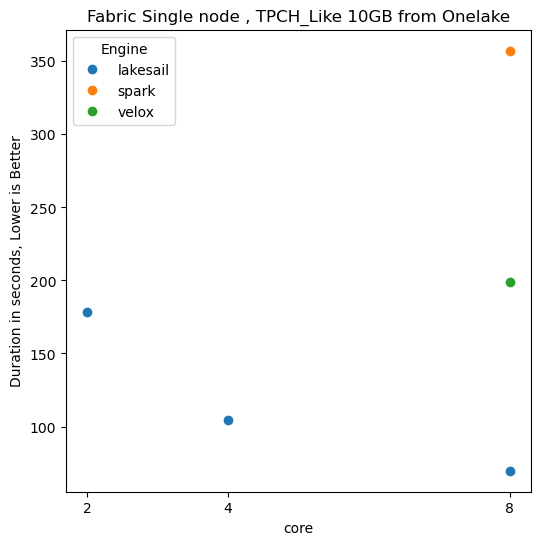

In [13]:
df= spark.read.format('delta').load(table_results)
df.createOrReplaceTempView("my_table")
ff = spark.sql(f""" 
WITH xx as (
select
              Engine,
              sf,
              cpu as core,
              test,
              query,
              avg(dur) as dur
              from my_table
              where  sf = {SF}
              group by 1,2,3,4,5)
SELECT        
              core,
              Engine,
              sum(dur) as dur from xx
              group by 1,2
              order by 1 desc
   """).toPandas()
pivoted_ff = ff.pivot(index='core', columns='Engine', values='dur').sort_index()
ax = pivoted_ff.plot(
    style='o',
    rot=0,
    title=f"Fabric Single node , TPCH_Like {SF}GB from Onelake",
    ylabel='Duration in seconds, Lower is Better',
    figsize=(6, 6)
)
target_ticks = [2,4, 8]
ax.set_xticks(target_ticks)
ax.set_xticklabels(target_ticks)